# Fundamental Analysis
This notebook uses machine learning to conduct a fundamental analysis of stocks. Specifically, a ML algorithm is trained on stocks at year X to predict whether the stock moved up or down at year X+1. This problem is cast as a classification problem (vs. regression problem), as it is easier to train. 

In [2]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt

# from pandas_datareader.data import DataReader
# import fix_yahoo_finance
import pandas_datareader.data as pdweb
from pandas_datareader import data as pdr
import fix_yahoo_finance # must pip install first

from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
from forex_python.converter import CurrencyRates
import datetime
import pickle
%matplotlib inline

In [8]:
data = pdr.get_data_yahoo('SPY','2017-05-20','2017-05-23')
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-22,238.899994,239.710007,238.820007,239.520004,237.180557,61010600
2017-05-23,239.949997,240.240005,239.509995,240.050003,237.705383,48341700


- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [2]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")
#tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
#tickers = tickers.loc[tickers['MarketCap']>1e6]  #exclude stocks with small market cap
tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


## Get Data

In [19]:
############################################# Helper Functions #############################################
#############################################                  #############################################
#simple progress bar
def progress_bar(stocks, every=10):
    length = float(len(stocks))
    i=0
    for index, item in stocks.iterrows():
        if i % every == 0:
            print >>sys.stderr, i/length,
        yield item[0], item[1]
        i += 1

#small helper function to get first/last day of a month for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS')[0], pd.date_range(date, periods=1, freq='BM')[0]

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock,current_date):
    ds = current_date.split('-')
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    mean_current_price = pdr.get_data_yahoo(stock, first_current, last_current)['Close'].mean()
    mean_past_price = pdr.get_data_yahoo(stock, first_past, last_past)['Close'].mean()
    #mean_current_price = DataReader(stock, 'google', first_current, last_current)['Close'].mean()
    #mean_past_price = DataReader(stock, 'google', first_past, last_past)['Close'].mean()
    if int(ds[0])+1 < 2017:
        mean_future_price = pdr.get_data_yahoo(stock, first_future, last_future)['Close'].mean()
        #mean_future_price = DataReader(stock, 'google', first_future, last_future)['Close'].mean()
    else:
        mean_future_price = 1
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price, mean_current_price

def clean_data(d):
    #delete annoying repeated columns
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    
    #convert commas to dots in relevant columns
    for c in d.columns:
        try:
            d[c]=d[c].str.replace(',','.')
        except:
            pass
    return d

#convert all currency values into USD
def convert_currency(values,date):
    currencies = ['AED','ARS','AUD','BRL','CAD','CHF','CLP','CNY','COP','CZK','EUR','GBP','HKD','ILS','INR','JPY','KRW','MXN','OMR','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR']
    date = date.split("-")
    year, month = int(date[0]), int(date[1])
    for c in currencies:
        mask = values.index.str.contains(c)
        if np.any(mask):
            cr = CurrencyRates()
            values.loc[values.index[mask]] *= cr.get_rate(c, 'USD', datetime.datetime(year, month, 1))
            values.index = [col.replace(c, 'USD') for col in values.index]
            return values
    return values

In [20]:
############################################# Main Functions #############################################
#############################################                #############################################

#scrape financial data from Morningstar for a given stock
def get_stock_financials(stock,company,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    
    #load/scrape data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
        #ensure that data gathered from Morningstar corresponds to ticker of interest
        remove_suffix = ['Inc','Corp','Ind','In','I','L','R','Ad','C','Co','E']
        #remove annoying suffix that by chance could match another unrelated company. Make case insensitive
        company_name = [x.upper() for x in company.split() if x not in remove_suffix]
        company_header = open('%s%s_keyratios.csv'%(path, stock)).readline().upper()
        matches = [s for s in company_name if s in company_header]
        if len(matches) == 0:
            return pd.DataFrame(columns=d.columns)  #return empty DataFrame which will be ignored
    
    #clean data
    d = d.transpose().reset_index()
    d = clean_data(d)
    
    #get indices for years of interest
    if year == "TTM":
        i_current = np.where(d['index'].str.contains("TTM"))[0][0]
        i_past = np.where(d['index'].str.contains("2015"))[0][0]
        date_current = "2016-12"
        date_past = d['index'].iloc[i_past]
    else:
        i_current = np.where(d['index'].str.contains("%d"%year))[0][0]
        i_past = np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
        date_current = d['index'].iloc[i_current]
        date_past = d['index'].iloc[i_past]
    
    #convert data from string to numeric, do currency conversion (if need be), get YOY-ratios
    values_current = convert_currency(pd.to_numeric(d.iloc[i_current], errors='coerce'), date_current)
    values_past = convert_currency(pd.to_numeric(d.iloc[i_past], errors='coerce'), date_past)
    YOY = values_current/values_past
    YOY = YOY.add_suffix(' YOY')
    
    #final dataframe
    d = pd.DataFrame(pd.concat([values_current, YOY])).transpose()
    
    #get Fractional price changes (future/current -> for target and current/past -> for features)
    d['Stock'] = stock
    MFFPC, MPFPC, MP = get_mean_frac_price_change(stock,date_current)
    d['Mean Future Fractional Price Change'] = MFFPC
    d['Mean Past Fractional Price Change'] = MPFPC
    d['Mean Price'] = MP
    return d

###############################################
#Top-level function which gets a validation set, i.e. data we want to predict on that we don't know the answer to
# def validation_set(stocks, columns, year):
#     X = get_stock_financials(stocks[0][0],stocks[0][1],year)
#     X = feature_engineering(X)[columns]
#     for s,c in zip(*stocks[1:]):
#         _X = get_stock_financials(s,c,year)
#         X.append(feature_engineering(_X)[columns])
#     return X

###############################################
#Top-level function which compiles all stock data into a single DataFrame
def get_data(ticker_csv,year,true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_data.csv"%(ticker_loc,year))
        skip = np.loadtxt("%s_year%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        print "Loaded data from csv's..."
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],stocks["Company"][0],year).columns
        X = pd.DataFrame(columns=cols)                                     #empty dataframe with available columns
        skip = []
        for s,c in progress_bar(stocks, len(stocks["Symbol"])/10):         #main loop, fill dataframe
            try:
                _X = get_stock_financials(s,c,year)
                if _X.shape[1] >= 1:                                       #only append if alg recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_data.csv"%(ticker_loc,year))
        np.savetxt("%s_year%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    
    #create target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change']>true_threshold)] = 1
    return X, y, skip

Load the data below. This will take a minute.

In [ ]:
year = 2013
true_threshold=1.0  #Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
ticker_csv = "csv/wilshire5000.csv"
#ticker_csv = 'csv/nasdaq/Finance.csv'

X, y, skip = get_data(ticker_csv, year, true_threshold)

Couldn't find DataFrame, scraping data from Morningstar...


0.0 0.0999756750182 0.199951350036

In [32]:
#Relative class numbers
print "Number of True cases = %d"%len(y[y==1])
print "Number of False cases = %d"%len(y[y==0])
print "Total cases = %d"%len(y)

Number of True cases = 1699
Number of False cases = 798
Total cases = 2497


## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [33]:
#delete columns with >10% NaN values...
#for remaining columns, replace NaN values with median
deleted_columns = []
remaining_columns = []
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        deleted_columns.append((c,frac_NaN))
        print "deleted %s"%c
    else:
        try:
            remaining_columns.append((c,frac_NaN))
            X[c].fillna(X[c].median(), inplace=True)
        except:
            print "!couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

!couldnt convert Stock column to numeric. NaN fraction=0.0000
deleted Accounts Payable
deleted Accounts Payable YOY
deleted Accounts Receivable
deleted Accounts Receivable YOY
deleted Accrued Liabilities
deleted Accrued Liabilities YOY
deleted COGS
deleted COGS YOY
deleted Cap Ex as a % of Sales YOY
deleted Cap Spending USD Mil YOY
deleted Cash Conversion Cycle
deleted Cash Conversion Cycle YOY
deleted Current Ratio
deleted Current Ratio YOY
deleted Days Inventory
deleted Days Inventory YOY
deleted Days Sales Outstanding
deleted Days Sales Outstanding YOY
deleted Debt/Equity
deleted Debt/Equity YOY
deleted Dividends USD
deleted Dividends USD YOY
deleted EBT Margin YOY
deleted Financial Leverage (Average) YOY
deleted Financial Leverage YOY
deleted Fixed Assets Turnover YOY
deleted Free Cash Flow Growth % YOY
deleted Free Cash Flow Growth % YOY YOY
deleted Free Cash Flow/Sales % YOY
deleted Gross Margin
deleted Gross Margin %
deleted Gross Margin % YOY
deleted Gross Margin YOY
deleted In

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [34]:
#feature engineering
def feature_engineering(X):
    X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
    X['P/E Ratio'] = X['Mean Price']/X['Earnings Per Share USD']                 
    X['P/B Ratio'] = X['Mean Price']/X['Book Value Per Share * USD']
    X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

    X['Working Capital Ratio YOY'] = X['Total Assets YOY']/X['Total Liabilities YOY']   
    X['P/E Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD YOY']                 
    X['P/B Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD YOY']
    X['D/E Ratio YOY'] = X['Total Liabilities YOY']/X["Total Stockholders' Equity YOY"] 
    return X

X = feature_engineering(X)

columns = X.columns.tolist()
remove = ['Mean Future Fractional Price Change','Stock']
features = [x for x in columns if x not in remove]

In [35]:
X[features].head()

,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,Cash & Short-Term Investments YOY,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
0,0.44,0.44,0.676923,0.676923,12.36,0.734403,2.43,-98.0,26.78,0.957797,...,55.72,1.139002,2.258356,29.630282,2.876726,0.794688,1.153568,1.268805,1.279754,0.761083
1,0.38,0.38,0.974359,0.974359,11.40,1.018060,27.02,-18.0,8.04,1.163531,...,100.00,1.546073,1.644196,0.126457,0.011404,0.608200,0.992956,1.116002,4.256461,0.651388
2,0.53,0.53,1.019231,1.019231,5.05,1.018145,0.19,-0.0,4.97,0.961315,...,32.58,0.991177,1.483239,25.086183,0.943837,2.069368,0.995699,1.238390,1.216320,1.013260
3,1.24,1.24,0.976378,0.976378,18.50,1.116476,1.90,-61.0,1.40,1.386139,...,51.40,1.032129,2.057613,12.284312,1.235071,0.945525,1.032922,0.466568,0.719705,0.937991
4,1.54,1.54,0.968553,0.968553,3.74,1.129909,5.85,-21.0,8.74,0.509027,...,76.84,1.029061,4.317789,27.779792,6.239312,0.301406,1.093696,1.047728,0.973631,0.888510


In [36]:
#training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

#validation set - stocks in (ticker, company name) format
#stocks = [('AQN','Algonquin Power & Utilities Corp')]
#X_valid = validation_set(stocks, features, "TTM")

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [37]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [38]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.46021840873634945

Grid search for optimum best parameters

In [39]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
n_iter = 20     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.05,0.1,0.2,0.5,1,3],
    'max_delta_step': [0,1,5,10],
    'colsample_bytree': [0.1,0.5,1],
    'gamma': [0,0.2,0.4,0.8],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 

Final Model with best parameters from grid search

In [40]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[3000],
    'max_depth': [8],
    'max_delta_step': [5],
    'min_child_weight': [0.1],
    'colsample_bytree': [0.5],
    'gamma': [0.2],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.71341532222


In [15]:
pickle.dump(xgb_model, open("pima.pickle.dat", "wb"))

In [13]:
xgb_model = pickle.load(open("pima.pickle.dat", "rb"))

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


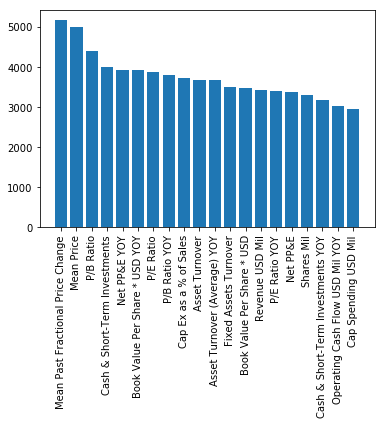

In [41]:
#model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)[0:20]
plt.bar(range(len(feat_imp)),feat_imp, tick_label=feat_imp.keys())
plt.xticks(rotation=90);

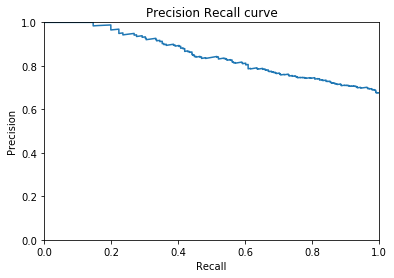

In [42]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

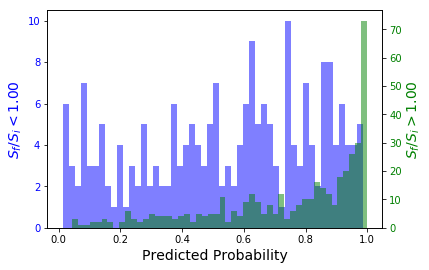

In [43]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.2f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.2f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

Helpful links in making this notebook:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  
https://www.boxcontrol.net/write-simple-currency-converter-in-python.html  

### Validation Set Predictions

In [18]:
y_pred_valid = xgb_model.predict_proba(X_valid)
y_pred_valid[:,1]

array([ 0.95250666], dtype=float32)

### Analysis of misclassified stocks

In [19]:
XX = X_test
XX['y_pred'] = y_pred[:,1]
XX['y_test'] = y_test

In [20]:
#what cut are you making
index = XX[(XX['y_test']==0) & (XX['y_pred']>0.9)].index
#index = XX[(np.abs(XX['P/E Ratio'])>1e2)].index
X.loc[index]

,Stock,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Spending USD Mil,Cash & Short-Term Investments,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
134,AME,0.61,0.61,0.938462,0.938462,14.0800,0.979819,1.74,-69.000,5.72,...,48.84,0.968087,1.954652,21.933707,3.816590,1.047502,0.968530,1.023249,1.079576,1.066528
1546,MTSC,1.19,1.19,0.991667,0.991667,17.0000,1.020408,3.27,-18.000,11.23,...,56.02,1.057779,2.273761,18.800950,3.317815,0.785077,1.069577,0.782121,0.842285,0.883879
1133,HT,0.25,0.25,1.086957,1.086957,16.2700,0.966152,29.41,-138.000,1.42,...,34.42,0.770022,1.524855,37.165585,1.279209,1.905288,0.843245,1.503441,0.837906,1.540079
1811,PNBK,0.04,0.04,1.333333,1.333333,15.3900,1.001953,27.59,-6.000,13.07,...,9.40,1.012931,1.103753,28.176033,1.006941,9.638298,1.001325,6.885586,0.933257,0.985928
96,AIRM,0.74,0.74,0.961039,0.961039,14.3600,1.255245,15.36,-167.000,0.37,...,36.85,1.062879,1.583531,15.584249,2.962744,1.713704,1.034521,0.887259,0.784422,0.909446
1988,SBNY,0.03,0.03,0.991228,0.991228,55.4300,1.018060,1.20,-12.000,1.02,...,8.65,0.984635,1.094691,21.217207,2.782773,10.560694,0.992956,1.267163,1.227863,1.022809
801,ENS,1.12,1.12,0.973913,0.973913,25.4600,0.944712,2.54,-64.000,12.43,...,48.03,0.894747,1.924187,16.972943,2.513276,1.082032,0.891283,0.739282,0.976889,1.253961
2092,SPG,0.17,0.17,1.133333,1.133333,13.8100,0.872394,19.39,-1.021,3.48,...,14.59,0.845797,1.170823,30.934246,13.171134,5.854010,0.968856,0.823430,1.227871,1.220322
565,CRS,0.75,0.75,1.027397,1.027397,27.8200,1.037286,7.66,-171.000,2.41,...,45.63,0.927439,1.839250,36.233235,1.445683,1.191541,0.934339,1.506164,0.652529,1.154012
414,CCE,0.92,0.92,0.938776,0.938776,4.6746,0.540978,4.58,-311.640,2.23,...,12.57,0.750448,1.143772,14.203920,7.472357,6.955449,0.952190,1.265108,2.135288,1.399445


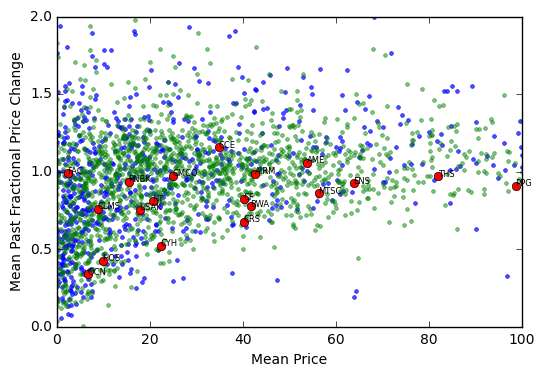

In [21]:
def plot_labels(a,x,y,size,xlo=None,xhi=None,ylo=None,yhi=None):
    arr = a.loc[(a[y]>ylo)&(a[y]<yhi)&(a[x]>xlo)&(a[x]<xhi)]
    arrx, arry, arrnames = arr[x].values, arr[y].values, arr["Stock"].values
    for i in range(len(arrx)):
        plt.text(arrx[i], arry[i], arrnames[i], size=size)

#features to plot
feature_x = "Mean Price"
feature_y = "Mean Past Fractional Price Change"
plt.plot(X.loc[y==0,feature_x], X.loc[y==0,feature_y], '.', alpha=0.7)   #false cases
plt.plot(X.loc[y==1,feature_x], X.loc[y==1,feature_y], '.', alpha=0.5)   #true cases
plt.plot(X[feature_x].loc[index], X[feature_y].loc[index], 'o')          #misclassified cases

xlo,xhi,ylo,yhi = 0,100,0,2
plot_labels(X.loc[index],feature_x,feature_y,6,xlo,xhi,ylo,yhi)
plt.xlim([xlo,xhi])
plt.ylim([ylo,yhi])
plt.xlabel(feature_x)
plt.ylabel(feature_y)

# Extra